In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud as wc
from textblob import TextBlob
from bs4 import BeautifulSoup
import re
import nltk
from nltk import TreebankWordTokenizer
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from nltk.stem import WordNetLemmatizer

In [10]:
stock_df = pd.read_csv('upload_DJIA_table.csv')

In [11]:
stock_df = stock_df.round(1)

In [12]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1989 non-null   object 
 1   Open       1989 non-null   float64
 2   High       1989 non-null   float64
 3   Low        1989 non-null   float64
 4   Close      1989 non-null   float64
 5   Volume     1989 non-null   int64  
 6   Adj Close  1989 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 108.9+ KB


In [13]:
stock_df

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.2,18002.4,17916.9,17949.4,82160000,17949.4
1,2016-06-30,17712.8,17930.6,17711.8,17930.0,133030000,17930.0
2,2016-06-29,17456.0,17704.5,17456.0,17694.7,106380000,17694.7
3,2016-06-28,17190.5,17409.7,17190.5,17409.7,112190000,17409.7
4,2016-06-27,17355.2,17355.2,17063.1,17140.2,138740000,17140.2
...,...,...,...,...,...,...,...
1984,2008-08-14,11532.1,11718.3,11450.9,11615.9,159790000,11615.9
1985,2008-08-13,11632.8,11633.8,11453.3,11533.0,182550000,11533.0
1986,2008-08-12,11781.7,11782.3,11601.5,11642.5,173590000,11642.5
1987,2008-08-11,11729.7,11867.1,11675.5,11782.3,183190000,11782.3


In [14]:
for index, row in stock_df.iterrows():
    if row["Close"] > row["Open"]:
        stock_df.at[index, "Direction"] = "Up"
    else:
        stock_df.at[index, "Direction"] = "Down"

In [15]:
stock_df["Direction"].unique()

array(['Up', 'Down'], dtype=object)

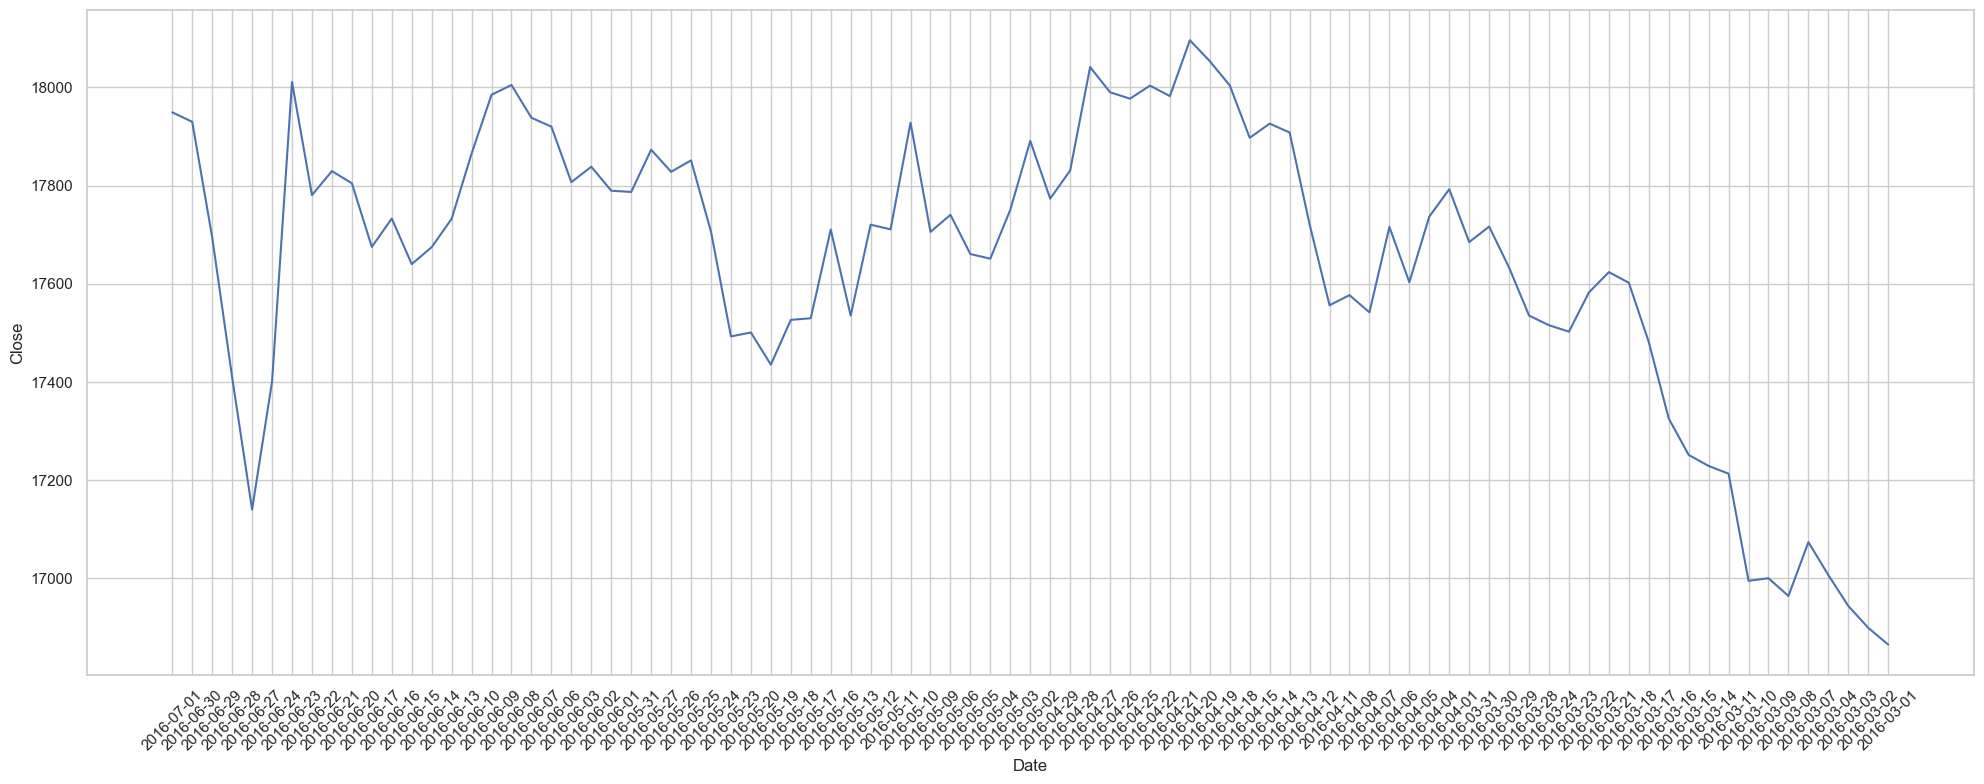

In [32]:
# Plot the responses for different events and regions
newest_stock_df = stock_df.loc[stock_df["Date"] >= "2016-03-01"]

plt.figure(figsize=(20, 8))
sns.lineplot(x="Date", y="Close", data=newest_stock_df)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


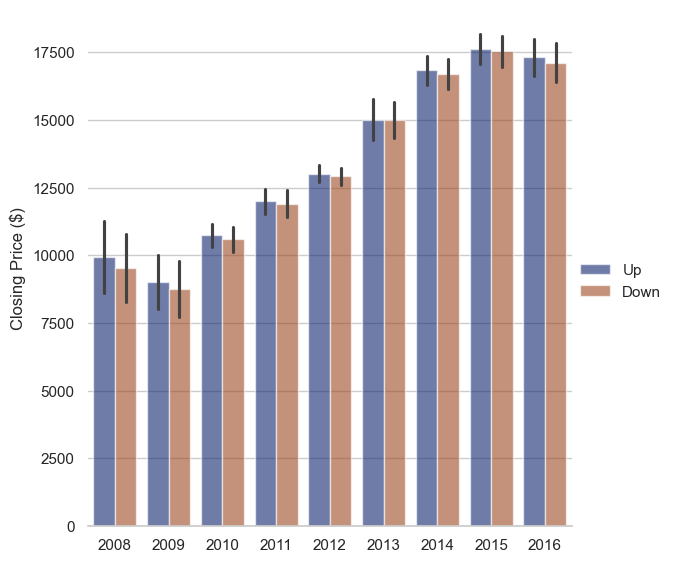

In [33]:
sns.set_theme(style="whitegrid")

stockPerYear_df = stock_df
stockPerYear_df["Year"] = pd.to_datetime(stockPerYear_df['Date']).dt.strftime('%Y')
stockPerYear_df=stockPerYear_df.sort_values(by="Year", ascending=True)

g = sns.catplot(
    data=stockPerYear_df, kind="bar",
    x="Year", y="Close", hue="Direction",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Closing Price ($)")
g.legend.set_title("")

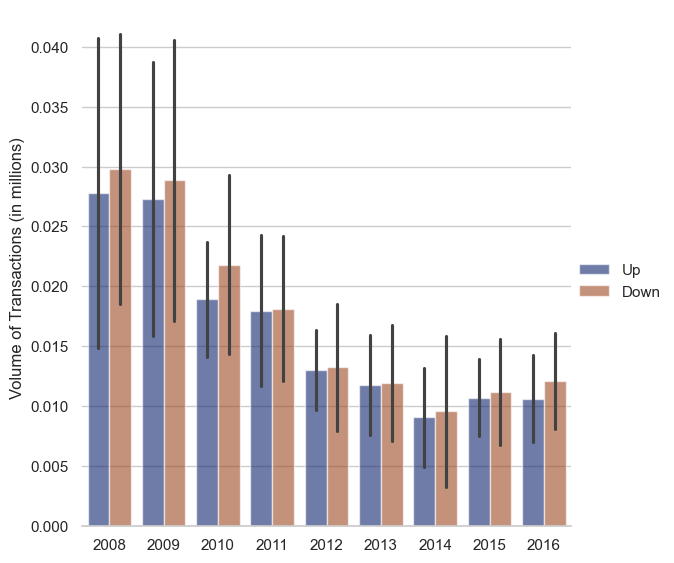

In [34]:
sns.set_theme(style="whitegrid")

volumePerYear_df = stock_df
volumePerYear_df["Year"] = pd.to_datetime(volumePerYear_df['Date']).dt.strftime('%Y')
volumePerYear_df["Volume"] = volumePerYear_df["Volume"]/100000
volumePerYear_df=volumePerYear_df.sort_values(by="Year", ascending=True)

g = sns.catplot(
    data=volumePerYear_df, kind="bar",
    x="Year", y="Volume", hue="Direction",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Volume of Transactions (in millions)")
g.legend.set_title("")

In [35]:
news_df = pd.read_csv('RedditNews.csv')

In [36]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73608 entries, 0 to 73607
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    73608 non-null  object
 1   News    73608 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [37]:
news_df

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
...,...,...
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."


In [38]:
#list of possible keywords to filter on
keywords = [
    'earnings report', 'economic data', 'federal reserve', 'interest rates', 'inflation',
    'unemployment rate', 'gross domestic product', 'consumer confidence', 'consumer spending',
    'corporate profits', 'federal open market committee', 'monetary policy', 'fiscal policy',
    'trade war', 'tariffs', 'trade negotiations', 'federal budget', 'corporate mergers',
    'acquisitions', 'initial public offering', 'stock split', 'dividend announcement',
    'analyst upgrade', 'analyst downgrade', 'regulatory approval', 'legal settlements',
    'litigation', 'government shutdown', 'election results', 'political unrest', 'geopolitical tension',
    'natural disasters', 'energy prices', 'oil prices', 'renewable energy',
    'technology innovation', 'cybersecurity breaches', 'data breaches', 'product recalls',
    'supply chain disruptions', 'labor strikes', 'currency fluctuations', 'exchange rates',
    'global economic indicators', 'central bank actions', 'global pandemic', 'health crisis',
    'international conflicts', 'corporate scandals'
]

filteredNews_df = news_df[news_df['News'].str.contains('|'.join(keywords), case=False)]
filteredNews_df

,Date,News
537,2016-06-10,"For the first time ever, India has crossed a m..."
634,2016-06-06,Hours before the Federal Reserve Bank of New Y...
769,2016-06-01,Developing world invests more in renewable ene...
773,2016-06-01,BBC News: Renewable energy surges to record le...
801,2016-05-30,IKEA vows to be net exporter of renewable ener...
...,...,...
72877,2008-07-07,"b""Don't envy us, Saudis say, as inflation leav..."
73031,2008-07-01,b'IMF to investigate the US Federal reserve?'
73050,2008-06-30,b'Oil prices pass $143 a barrel; US gas hits h...
73326,2008-06-19,b'Mexico freezes prices on 150 food items beco...


In [39]:
for index, row in filteredNews_df.iterrows():
    if "b\"" in row["News"]:
        new_text = row["News"].replace("b\"", "")
        filteredNews_df.at[index, "News"] = new_text

    if "b'" in row["News"]:
        new_text = row["News"].replace("b'", "")
        filteredNews_df.at[index, "News"] = new_text
filteredNews_df

,Date,News
537,2016-06-10,"For the first time ever, India has crossed a m..."
634,2016-06-06,Hours before the Federal Reserve Bank of New Y...
769,2016-06-01,Developing world invests more in renewable ene...
773,2016-06-01,BBC News: Renewable energy surges to record le...
801,2016-05-30,IKEA vows to be net exporter of renewable ener...
...,...,...
72877,2008-07-07,"Don't envy us, Saudis say, as inflation leaves..."
73031,2008-07-01,IMF to investigate the US Federal reserve?'
73050,2008-06-30,Oil prices pass $143 a barrel; US gas hits high'
73326,2008-06-19,Mexico freezes prices on 150 food items becous...


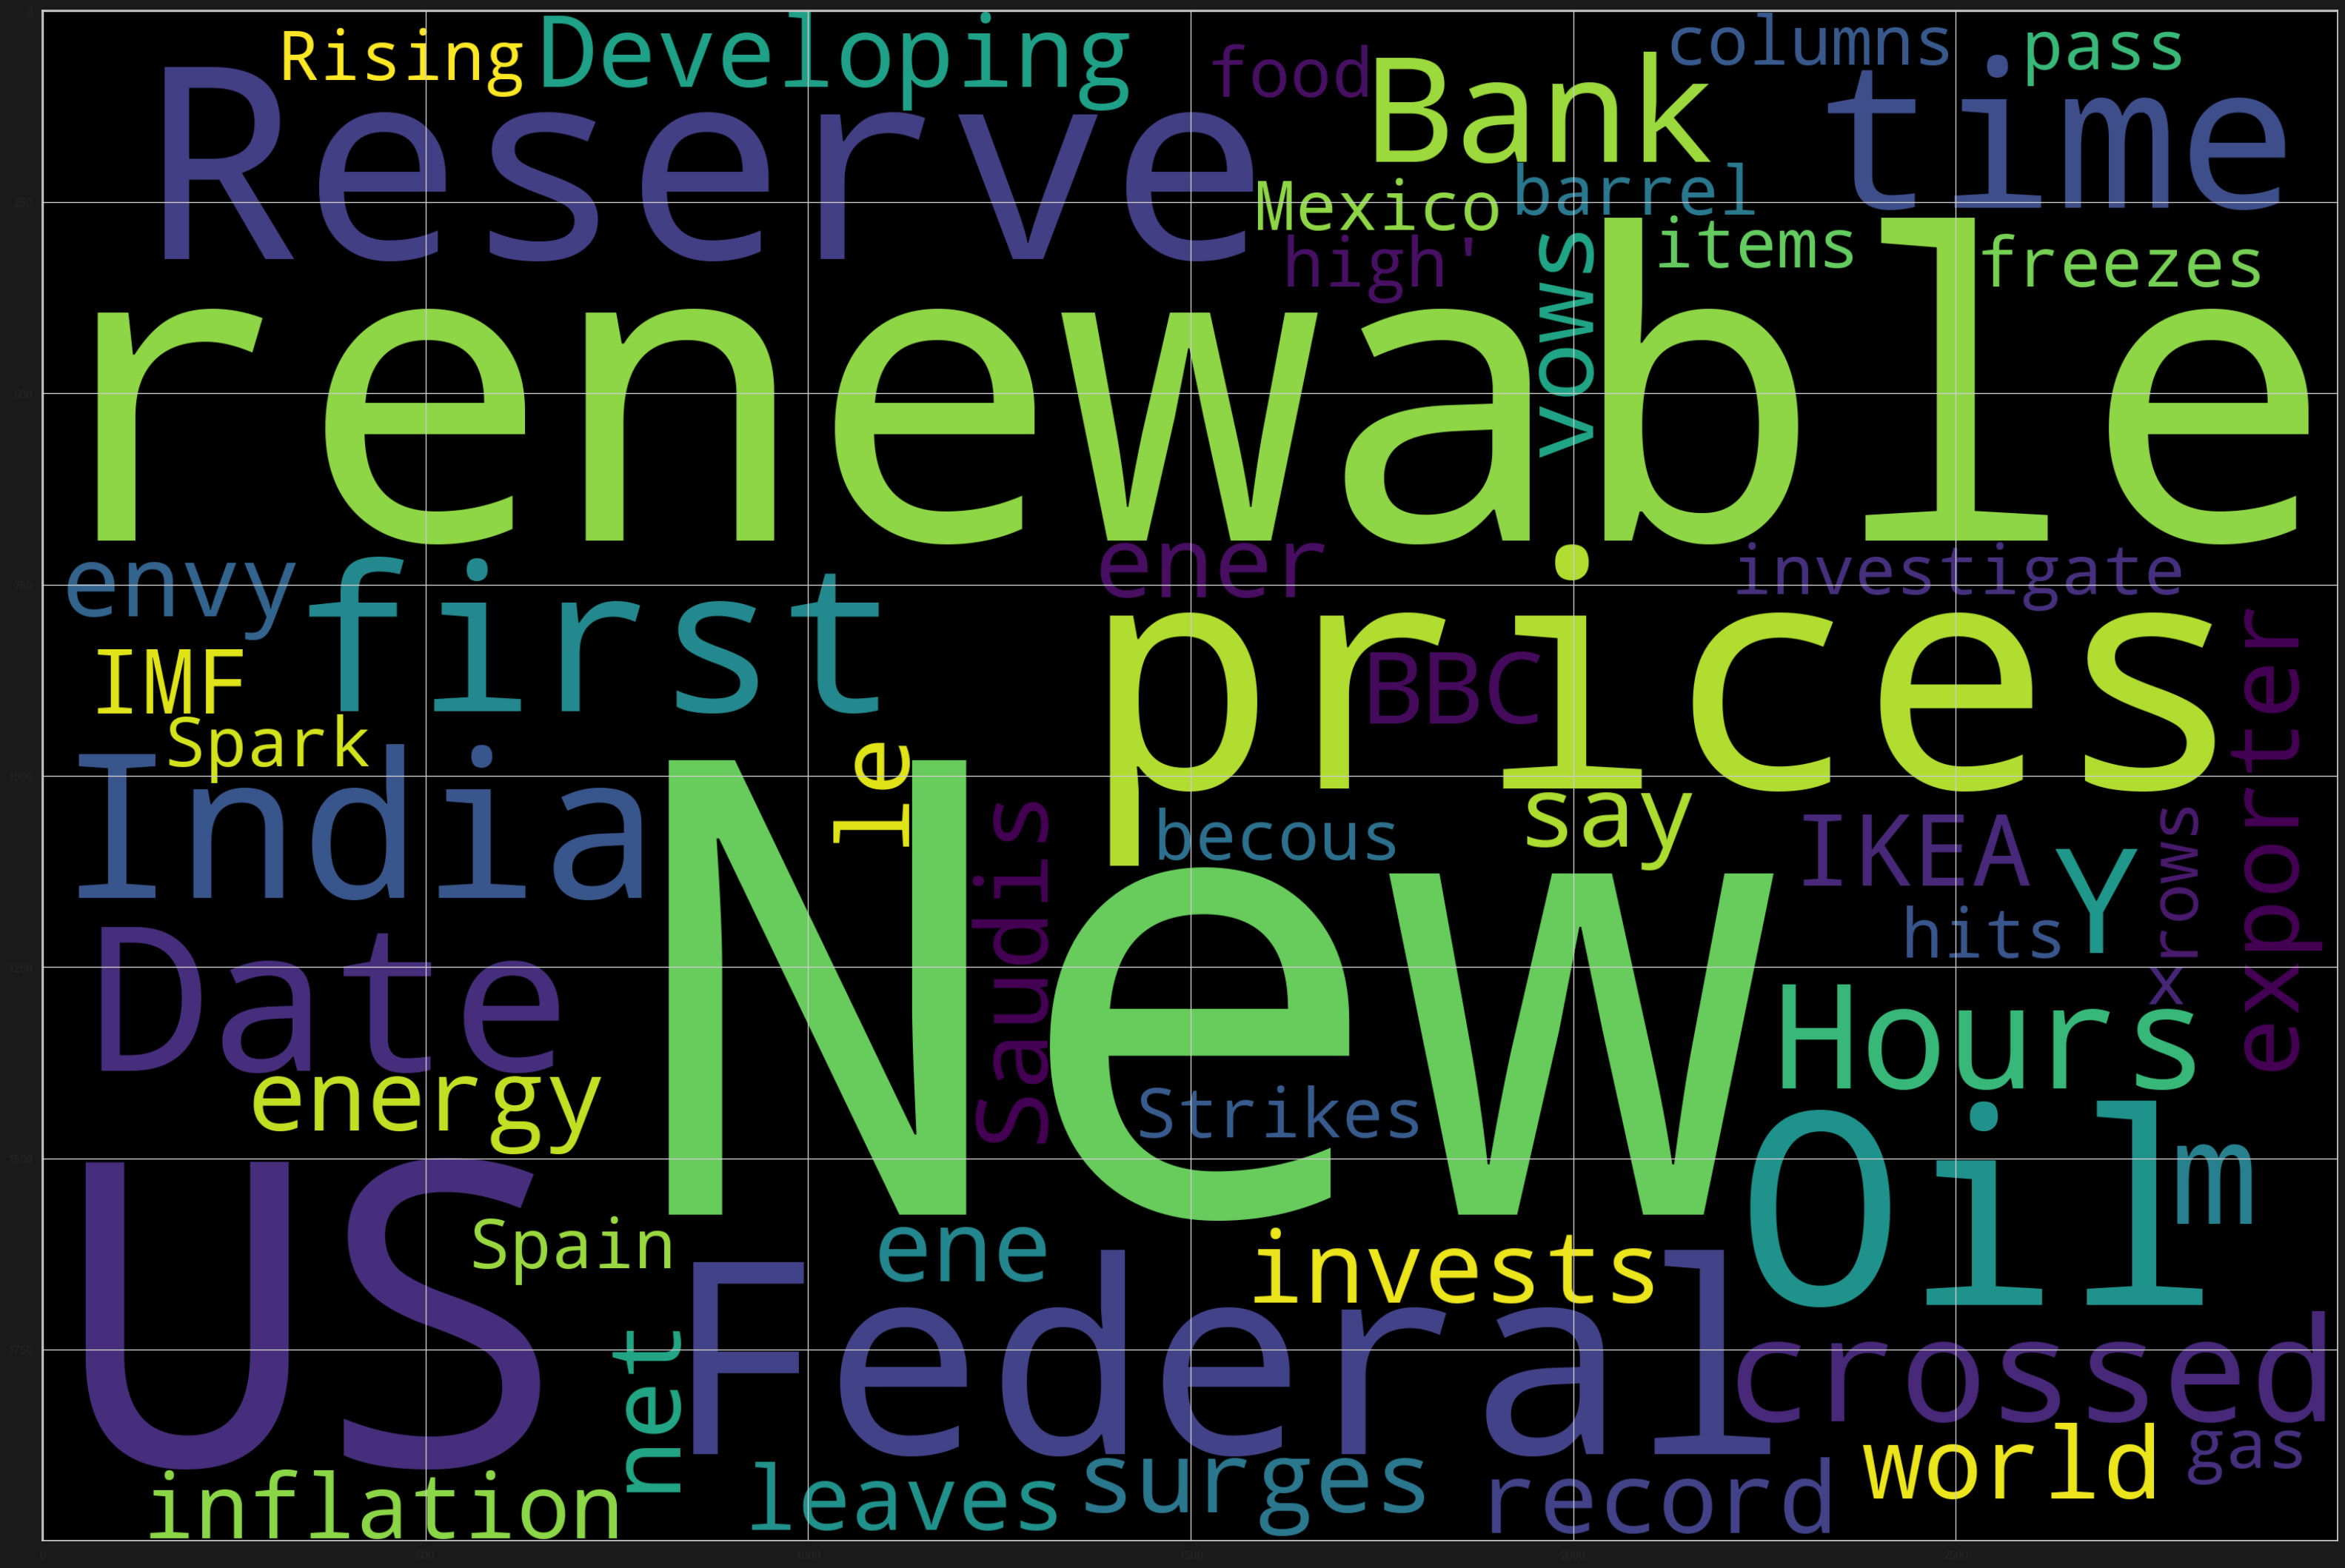

In [40]:
newestNews_df = filteredNews_df[filteredNews_df["Date"] >= "2008-01-01"]
text = newestNews_df

text = newestNews_df

wordcloud = wc.WordCloud(
    width = 3000,
    height = 2000,
    stopwords = wc.STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')

In [41]:
filtered_copy = filteredNews_df.copy()

filtered_copy['News'] = filtered_copy['News'].apply(lambda review : re.sub(r"[0-9]", " ", review.lower()))
filtered_copy

,Date,News
537,2016-06-10,"for the first time ever, india has crossed a m..."
634,2016-06-06,hours before the federal reserve bank of new y...
769,2016-06-01,developing world invests more in renewable ene...
773,2016-06-01,bbc news: renewable energy surges to record le...
801,2016-05-30,ikea vows to be net exporter of renewable ener...
...,...,...
72877,2008-07-07,"don't envy us, saudis say, as inflation leaves..."
73031,2008-07-01,imf to investigate the us federal reserve?'
73050,2008-06-30,oil prices pass $ a barrel; us gas hits high'
73326,2008-06-19,mexico freezes prices on food items becous...


In [42]:
tokenizer = TreebankWordTokenizer()

filtered_copy['News'] = filtered_copy['News'].apply(lambda review: tokenizer.tokenize(review))
filtered_copy['News']

537      [for, the, first, time, ever, ,, india, has, c...
634      [hours, before, the, federal, reserve, bank, o...
769      [developing, world, invests, more, in, renewab...
773      [bbc, news, :, renewable, energy, surges, to, ...
801      [ikea, vows, to, be, net, exporter, of, renewa...
                               ...                        
72877    [do, n't, envy, us, ,, saudis, say, ,, as, inf...
73031    [imf, to, investigate, the, us, federal, reser...
73050    [oil, prices, pass, $, a, barrel, ;, us, gas, ...
73326    [mexico, freezes, prices, on, food, items, bec...
73580    [rising, oil, prices, spark, strikes, in, spai...
Name: News, Length: 306, dtype: object

In [43]:
stop_words = stopwords.words('english')
np.unique(stop_words)

array(['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all',
       'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at',
       'be', 'because', 'been', 'before', 'being', 'below', 'between',
       'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did',
       'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don',
       "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further',
       'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
       "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him',
       'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn',
       "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma',
       'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't",
       'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o',
       'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours',
       'ourselves', 'out', 'over', 'own', 're', 's', 'same

In [44]:
negation_list = ["no","nor", "not", "n't"] #we want to retaint negations as they can affect sentiment analysis results

stop_words = [word for word in stop_words if word not in negation_list]
np.unique(stop_words)

array(['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all',
       'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at',
       'be', 'because', 'been', 'before', 'being', 'below', 'between',
       'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did',
       'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don',
       "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further',
       'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
       "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him',
       'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn',
       "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma',
       'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't",
       'my', 'myself', 'needn', "needn't", 'now', 'o', 'of', 'off', 'on',
       'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out',
       'over', 'own', 're', 's', 'same', 'shan', "shan't",

In [45]:
filtered_copy['News'] = filtered_copy['News'].apply(lambda review: [word for word in review if word not in stop_words])
# np.unique(filtered_copy['News'].tolist
filtered_copy['News']

537      [first, time, ever, ,, india, crossed, major, ...
634      [hours, federal, reserve, bank, new, york, app...
769      [developing, world, invests, renewable, energy...
773      [bbc, news, :, renewable, energy, surges, reco...
801      [ikea, vows, net, exporter, renewable, energy,...
                               ...                        
72877    [n't, envy, us, ,, saudis, say, ,, inflation, ...
73031       [imf, investigate, us, federal, reserve, ?, ']
73050    [oil, prices, pass, $, barrel, ;, us, gas, hit...
73326    [mexico, freezes, prices, food, items, becouse...
73580    [rising, oil, prices, spark, strikes, spain, s...
Name: News, Length: 306, dtype: object

In [46]:
filtered_copy['News'] = filtered_copy['News'].apply(lambda review : list(filter(None,[word for word in review if word not in string.punctuation])))
filtered_copy['News']

537      [first, time, ever, india, crossed, major, mil...
634      [hours, federal, reserve, bank, new, york, app...
769      [developing, world, invests, renewable, energy...
773      [bbc, news, renewable, energy, surges, record,...
801      [ikea, vows, net, exporter, renewable, energy,...
                               ...                        
72877    [n't, envy, us, saudis, say, inflation, leaves...
73031             [imf, investigate, us, federal, reserve]
73050     [oil, prices, pass, barrel, us, gas, hits, high]
73326    [mexico, freezes, prices, food, items, becouse...
73580    [rising, oil, prices, spark, strikes, spain, s...
Name: News, Length: 306, dtype: object

In [47]:
filtered_copy['News'] = filtered_copy['News'].apply(lambda review: list(filter(None,[re.sub(r"[-._'`*]+", '', word) for word in review])))

filtered_copy['News'] = filtered_copy['News'].apply(lambda review : list(filter(None,[word for word in review if len(word)>1])))

np.unique(filtered_copy['News'])

array([list(['abbott', 'government', 'extends', 'renewable', 'energy', 'investment', 'ban', 'solar', 'power', 'clean', 'energy', 'finance', 'corporation', 'banned', 'investing', 'smallscale', 'solar', 'projects', 'move', 'industry', 'claims', 'revenge', 'politics', 'strangle', 'sector']),
       list(['abbott', 'govt', 'gives', 'help', 'climate', 'contrarian', 'set', 'australian', 'center', 'bjrn', 'lomborg', 'given', 'money', 'set', 'consensus', 'center', 'says', 'climate', 'change', 'not', 'toppriority', 'problem', 'amp', 'overstated', 'subsidies', 'renewable', 'energy', 'make', 'no', 'sense']),
       list(['abbott', 'secret', 'trade', 'negotiations', 'deregulate', 'banking', 'finance', 'foreign', 'banks', 'workers', 'would', 'get', 'greater', 'access', 'local', 'bank', 'accounts', 'could', 'transferred', 'overseas', 'reports', 'say']),
       list(['actually', 'no', 'hyperinflation', 'iran']),
       list(['alphabet', 'google', 'parent', 'company', 'surpassed', 'apple', 'world', 'v

In [50]:
lemmatizer = WordNetLemmatizer()

filtered_copy['News'] = filtered_copy['News'].apply(lambda review: [lemmatizer.lemmatize(word) for word in review])
np.unique(filtered_copy['News'])


array([list(['abbott', 'government', 'extends', 'renewable', 'energy', 'investment', 'ban', 'solar', 'power', 'clean', 'energy', 'finance', 'corporation', 'banned', 'investing', 'smallscale', 'solar', 'project', 'move', 'industry', 'claim', 'revenge', 'politics', 'strangle', 'sector']),
       list(['abbott', 'govt', 'give', 'help', 'climate', 'contrarian', 'set', 'australian', 'center', 'bjrn', 'lomborg', 'given', 'money', 'set', 'consensus', 'center', 'say', 'climate', 'change', 'not', 'toppriority', 'problem', 'amp', 'overstated', 'subsidy', 'renewable', 'energy', 'make', 'no', 'sense']),
       list(['abbott', 'secret', 'trade', 'negotiation', 'deregulate', 'banking', 'finance', 'foreign', 'bank', 'worker', 'would', 'get', 'greater', 'access', 'local', 'bank', 'account', 'could', 'transferred', 'overseas', 'report', 'say']),
       list(['actually', 'no', 'hyperinflation', 'iran']),
       list(['alphabet', 'google', 'parent', 'company', 'surpassed', 'apple', 'world', 'valuable', '

In [51]:
from textblob import TextBlob

# Define a function to get sentiment polarity from text
def get_sentiment(text):
    # Create a TextBlob object for the text
    blob = TextBlob(text)
    # Get sentiment polarity (-1 to 1, where -1 is negative, 0 is neutral, and 1 is positive)
    polarity = blob.sentiment.polarity
    return polarity

In [52]:
filtered_copy['News'] = filtered_copy['News'].astype(str)

In [53]:
filtered_copy['Sentiment'] = filtered_copy['News'].apply(get_sentiment)

In [54]:
filtered_copy['Sentiment']

537      0.078125
634      0.136364
769      0.253788
773      0.000000
801      0.075758
           ...   
72877    0.400000
73031    0.000000
73050    0.160000
73326    0.000000
73580    0.000000
Name: Sentiment, Length: 306, dtype: float64

In [55]:
max = filtered_copy['Sentiment'].max()
min = filtered_copy['Sentiment'].min()
mean = filtered_copy['Sentiment'].mean()
print("The max sentiment is ", max," & the min is ",min)
print("The mean sentiment is ", mean)

The max sentiment is  0.8  & the min is  -0.7
The mean sentiment is  0.008044908704222432


In [56]:
filtered_copy = filtered_copy[~((filtered_copy['Sentiment']<0.01) & (filtered_copy['Sentiment']>0))]

In [57]:
filtered_copy = filtered_copy[~((filtered_copy['Sentiment']>-0.01) & (filtered_copy['Sentiment']<0))]

In [58]:
max = filtered_copy['Sentiment'].max()
min = filtered_copy['Sentiment'].min()
mean = filtered_copy['Sentiment'].mean()
print("The max sentiment is ", max," & the min is ",min)
print("The mean sentiment is ", mean)

The max sentiment is  0.8  & the min is  -0.7
The mean sentiment is  0.008230563225995125


In [59]:
filtered_copy['Sentiment'] = filtered_copy['Sentiment'].apply(lambda sentiment: 1 if sentiment >0.2 else -1 if sentiment <-0.2 else 0)

In [60]:
filtered_copy['Sentiment']

537      0
634      0
769      1
773      0
801      0
        ..
72877    1
73031    0
73050    0
73326    0
73580    0
Name: Sentiment, Length: 301, dtype: int64

<Axes: xlabel='Sentiment', ylabel='count'>

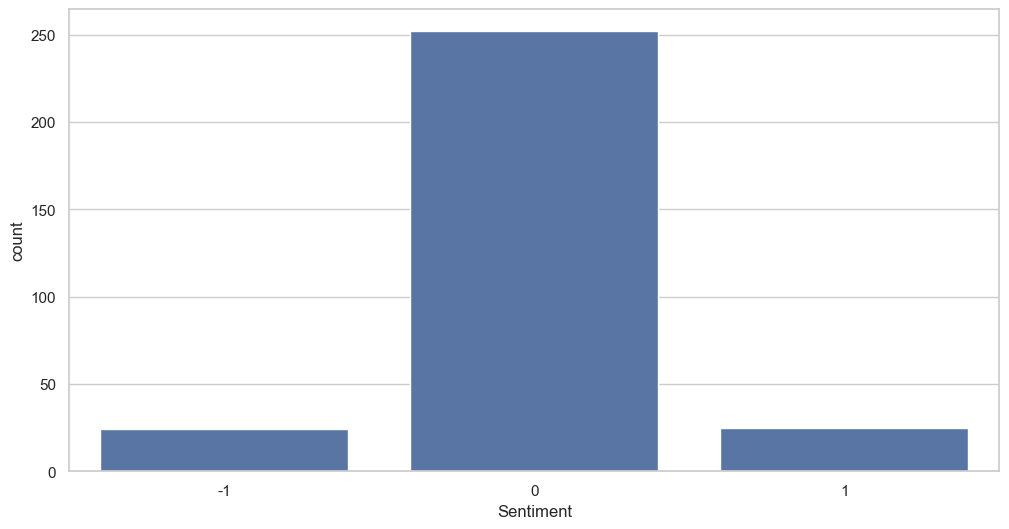

In [61]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 6))

sns.countplot(x = 'Sentiment', data = filtered_copy)

In [62]:
merged_df = pd.merge(stock_df, filtered_copy, on='Date', how='inner')

In [63]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       219 non-null    object 
 1   Open       219 non-null    float64
 2   High       219 non-null    float64
 3   Low        219 non-null    float64
 4   Close      219 non-null    float64
 5   Volume     219 non-null    float64
 6   Adj Close  219 non-null    float64
 7   Direction  219 non-null    object 
 8   Year       219 non-null    object 
 9   News       219 non-null    object 
 10  Sentiment  219 non-null    int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 18.9+ KB


In [64]:
merged_df

,Date,Open,High,Low,Close,Volume,Adj Close,Direction,Year,News,Sentiment
0,2016-06-10,17938.8,17938.8,17812.3,17865.3,0.009054,17865.3,Down,2016,"['first', 'time', 'ever', 'india', 'crossed', ...",0
1,2016-06-06,17825.7,17949.7,17822.8,17920.3,0.007187,17920.3,Up,2016,"['hour', 'federal', 'reserve', 'bank', 'new', ...",0
2,2016-06-01,17754.6,17809.2,17664.8,17789.7,0.007853,17789.7,Up,2016,"['developing', 'world', 'invests', 'renewable'...",1
3,2016-06-01,17754.6,17809.2,17664.8,17789.7,0.007853,17789.7,Up,2016,"['bbc', 'news', 'renewable', 'energy', 'surge'...",0
4,2016-05-25,17735.1,17891.7,17735.1,17851.5,0.007918,17851.5,Up,2016,"['sweden', 'phase', 'fossil', 'fuel', 'attempt...",1
...,...,...,...,...,...,...,...,...,...,...,...
214,2008-11-05,9616.6,9616.6,9111.5,9139.3,0.026464,9139.3,Down,2008,"['uk', 'interest', 'rate', 'slashed', 'lowest'...",0
215,2008-09-22,11394.4,11394.6,10992.2,11015.7,0.021321,11015.7,Down,2008,"['oil', 'price', 'shoot', 'barrel', 'biggest',...",0
216,2008-09-19,11027.5,11483.0,11026.7,11388.4,0.065511,11388.4,Up,2008,"['china', 'blame', 'wall', 'street', 'meltdown...",0
217,2008-09-03,11506.0,11554.4,11416.5,11532.9,0.017425,11532.9,Up,2008,"['oil', 'price', 'likely', 'drop', 'due', 'fal...",0


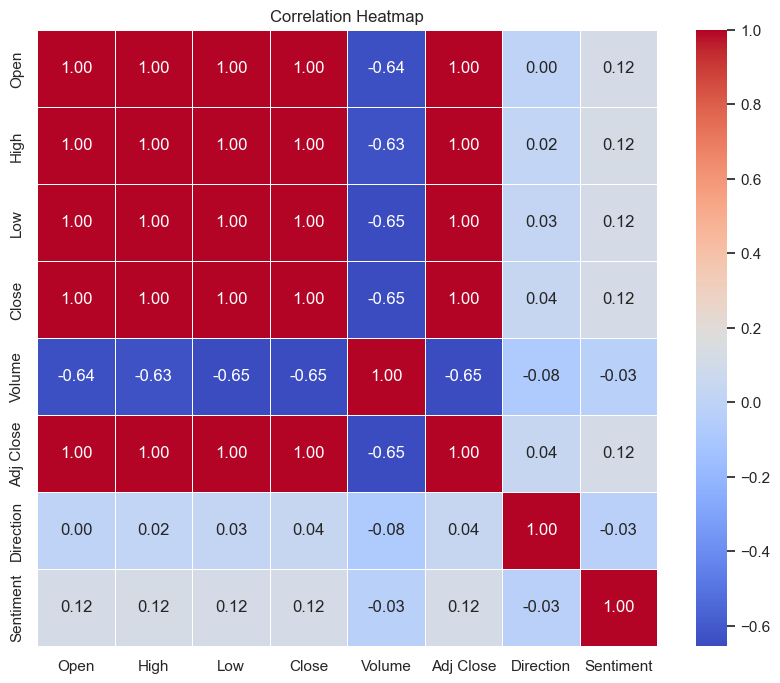

In [65]:
corr_copy_df = merged_df.copy()
corr_copy_df.drop(columns=['Date', 'Year',"News"], inplace=True)
corr_copy_df['Direction'] = corr_copy_df['Direction'].astype('category').cat.codes

corr_matrix = corr_copy_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

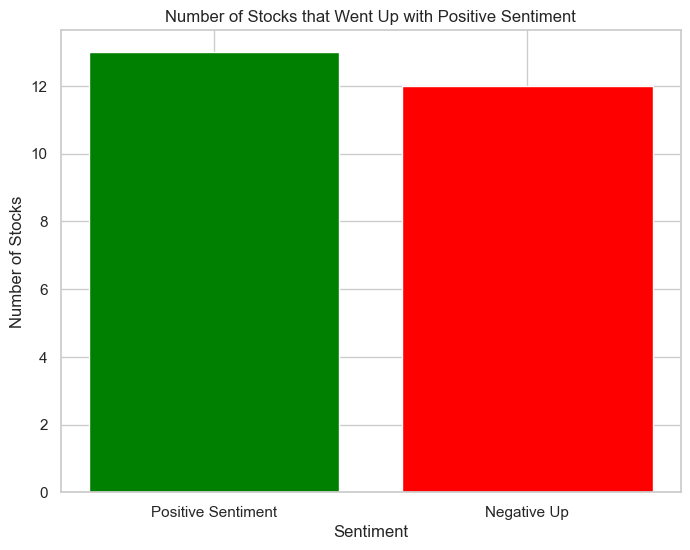

In [66]:
histo_copy_df = merged_df.copy()
positive_sentiment_up_count = histo_copy_df[(histo_copy_df['Sentiment'] > 0.2) & (histo_copy_df['Direction'] == 'Up')].shape[0]
neutral_sentiment_up_count = histo_copy_df[((histo_copy_df['Sentiment'] < 0.2)&(histo_copy_df['Sentiment'] > -0.2)) & (histo_copy_df['Direction'] == 'Up')].shape[0]
negative_sentiment_Down_count = histo_copy_df[(histo_copy_df['Sentiment'] < -0.2) & (histo_copy_df['Direction'] == 'Up')].shape[0]

# Calculate the total number of stocks for illustration purposes
total_stocks = histo_copy_df.shape[0]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar('Positive Sentiment', positive_sentiment_up_count, color='green')
plt.bar('Negative Up', negative_sentiment_Down_count, color='red')
plt.xlabel('Sentiment')
plt.ylabel('Number of Stocks')
plt.title('Number of Stocks that Went Up with Positive Sentiment')
plt.show()

In [67]:
merged_df['Direction'] = merged_df['Direction'].astype('category').cat.codes

In [68]:
indep_variables = selected_columns = ['High','Low','Close', 'Sentiment']
X = merged_df[indep_variables] #Independent Variable
y = merged_df['Direction'] #Dependent Variable

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the Support Vector Machine classifier
svm_classifier = SVC(kernel='linear')  # You can choose different kernels like 'rbf', 'poly', etc.

# Train the classifier on the training data
svm_classifier.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = svm_classifier.predict(x_test)


In [70]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8181818181818182


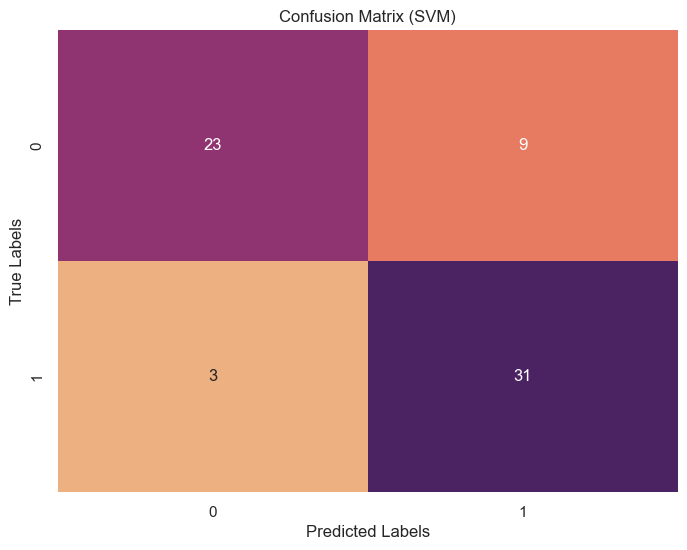

In [71]:
from sklearn.metrics import confusion_matrix

sns.set_theme(style="darkgrid")
# Calculate confusion matrix for SVM model
conf_matrix_svm = confusion_matrix(y_test, y_pred)

# Plot heatmap for SVM model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, cmap='flare', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SVM)')
plt.show()

In [72]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79        32
           1       0.78      0.91      0.84        34

    accuracy                           0.82        66
   macro avg       0.83      0.82      0.82        66
weighted avg       0.83      0.82      0.82        66



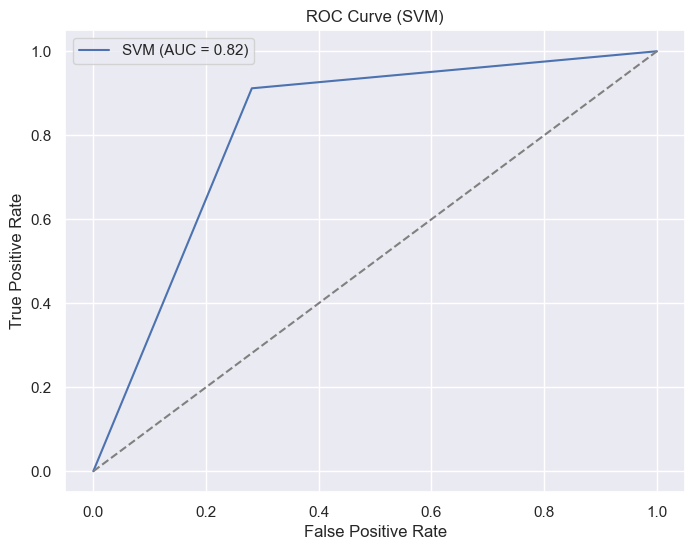

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve and AUC for SVM model
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred)
auc_svm = roc_auc_score(y_test, y_pred)

# Plot ROC curve for SVM model
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SVM)')
plt.legend()
plt.show()


In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree classifier
tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training data
tree_classifier.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = tree_classifier.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5303030303030303


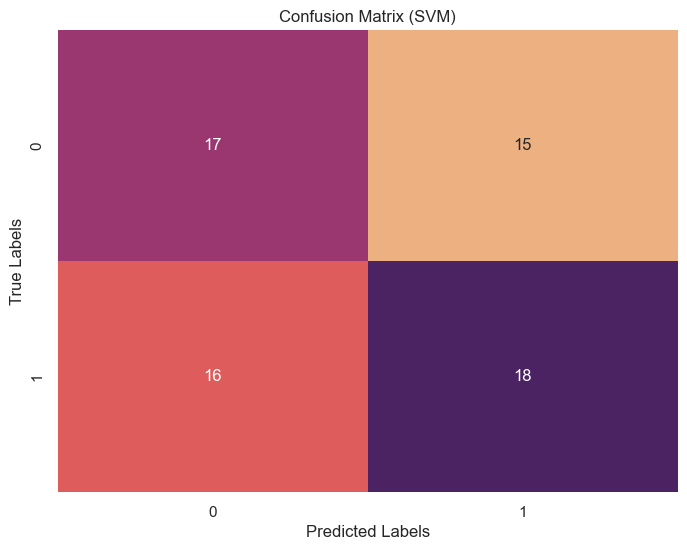

In [75]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix for SVM model
conf_matrix_dtree = confusion_matrix(y_test, y_pred)

# Plot heatmap for SVM model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dtree, annot=True, cmap='flare', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SVM)')
plt.show()

In [76]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.53      0.52        32
           1       0.55      0.53      0.54        34

    accuracy                           0.53        66
   macro avg       0.53      0.53      0.53        66
weighted avg       0.53      0.53      0.53        66

